# Find picture in picture 2


In order to identify important layout elements or structures in a document, pictures can be compared directly and smaller images can be detected in larger pictures. This is done in this example in order to identify tables in a newspaper. 

In this notebook, we assume that not each issue contains the selected type of table. Therefore a pre-selection is made by looping over all pages and all issues and checking whether there are any matches. The result of this pre-selection sensitively depends on the threshold used for defining a match. This threshold is a trade-off between finding all matches and finding false positives. It can be changed using the 'init_thrs'-parameter (see below).

Installation instruction for conda environment:

    conda install numpy matplotlib jupyter
    conda install opencv
    conda install imutils

First import all required packages

In [1]:
# general tools
import os, sys
import numpy as np

In [2]:
import cv2

In [3]:
from IPython.display import Image

In [4]:
import matplotlib.pyplot as plt

In [5]:
import imutils

## Subroutines

The best match for a given picture is found iteratively. The subroutines doing the iterations for improving the match and finding the best rotation angle are defined here.

In [6]:
# find best matching subpicture
def find_picture_match(img_rgb, template, init_thrs, step, loc, w, h):
    thrs = init_thrs
    n_loc = len(loc[0])
    while (thrs < 1.0 and n_loc > 0):
        res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
        threshold = thrs
        old_loc = loc
        loc = np.where(res >= threshold)
        n_loc = len(loc[0])
        thrs += step
        if n_loc < 1:
            loc = old_loc
    print('iteration converged at threshold = ', (thrs-step))
    print('number of matches found: ', len(loc[0]))
    return loc, thrs-step

In [7]:
# find best matching rotation
def find_rotation_match(img_rgb, template, init_rot, end_rot, rot_step, thrs):
    rotation = init_rot-rot_step
    n_loc = 0
    n_arr = []
    while (rotation <= end_rot):
        rotation += rot_step
        rotated = imutils.rotate(template, rotation)
        res = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= thrs)
        n_loc = len(loc[0])
        #print(rotation, n_loc)
        n_arr.append(n_loc)
    np_n_arr = np.array(n_arr)
    #print('maximum of matches found upon rotation: ', np.max(n_arr))
    if np.max(n_arr) == 0:
        print('no matches found upon rotation')
        rotation = 0.0
    else:
        rotation = init_rot + (np.argmax(np_n_arr)*rot_step)
    #print ('rotation_angle = ', rotation)
    return rotation

## find picture match in a given page

find the best match for the table from the template picture in the journal page

In [8]:
# select template and journal page; there are different templates for different years since the table format changes.
img_rgb = cv2.imread('01-04-1854_2.png')
template = cv2.imread('template2.png')

In [9]:
# scale template
#resize_f = 0.5 # resize factor
#res_template = cv2.resize(template, (int(template.shape[1]/resize_f), int(template.shape[0]/resize_f)))

In [10]:
# initialize variables for iterations
init_thrs = 0.07 # initial threshold
step = 0.01 # step for increasing threshold
w, h = template.shape[:-1]
res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= init_thrs)
n_loc = len(loc[0])
print ('initial matches found : ', n_loc)

initial matches found :  4146


In [11]:
# run subroutine for iterative picture matching
location, threshold = find_picture_match(img_rgb, template, init_thrs, step, loc, w, h)

iteration converged at threshold =  0.12999999999999998
number of matches found:  7


In [12]:
# these are the best matching locations
image = (location[::-1])
image

(array([104,  89,  89,  89,  89,  89,  89]),
 array([1068, 1398, 1399, 1400, 1401, 1402, 1403]))

In [13]:
#evaluate median location for cropping
loc0 = int(np.median(image[0]))
loc1 = int(np.median(image[1]))
loc0, loc1

(89, 1400)

In [14]:
# crop
crop_img = img_rgb[loc1:int(loc1+w), loc0:int(loc0+h)]

In [15]:
# save to file
result_name = 'result.png'
cv2.imwrite(result_name, crop_img)

True

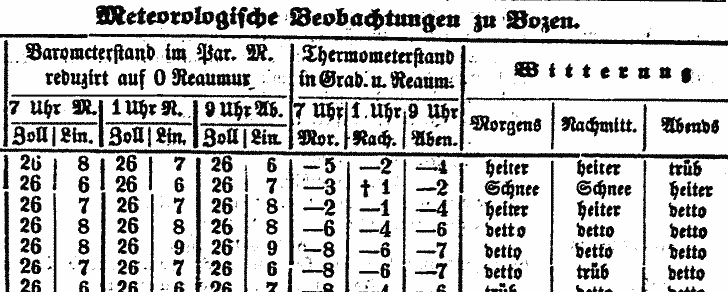

In [16]:
# what did we find?
Image(filename=result_name) 

### find optimal rotation

The picture may be rotated with respect to the template. We use the final threshold from above in order to find the optimal rotation.

In [17]:
init_rot = -2.0 # initial rotation angle
end_rot = 2.0 # final rotation angle
rot_step = 0.25 # rotation step
init_thrs = threshold # threshold 
print (init_thrs)
result2_name = 'result2.png'

0.12999999999999998


In [18]:
# find best matching rotation
rotation = find_rotation_match(img_rgb, template, init_rot, end_rot, rot_step, init_thrs)

In [19]:
# rotate by selected angle and initialize
rotated = imutils.rotate(template, rotation)
w, h = rotated.shape[:-1]
res = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= init_thrs)
n_loc = len(loc[0])
print ('rotation = ', rotation, ' instances found : ', n_loc)

rotation =  -0.5  instances found :  98


In [20]:
location, threshold = find_picture_match(img_rgb, rotated, init_thrs, step, loc, w, h)

iteration converged at threshold =  0.16
number of matches found:  10


In [21]:
image = (location[::-1])
image

(array([30, 31, 31, 73, 74, 81, 82, 88, 89, 90]),
 array([1397, 1397, 1398, 1398, 1398, 1398, 1398, 1398, 1398, 1398]))

In [22]:
#evaluate median location for cropping
loc0 = int(np.median(image[0]))
loc1 = int(np.median(image[1]))
loc0, loc1

(77, 1398)

In [23]:
# crop image with some extra borders
tol = 0.05 # 5 % extra border at each side
w_border = int(w*tol)
h_border = int(h*tol)
if len(image[0]) != 0:
    crop_img = img_rgb[int(loc1-w_border):int(loc1+w+w_border), int(loc0-h_border):int(loc0+h+h_border)]
    rot_crop_img = imutils.rotate(crop_img, -rotation) # invert rotation for result (rotation applies to template)
    cv2.imwrite(result2_name, rot_crop_img)
else:
    print ('no matches found, therefore no new locations; keep image without rotation')
    cv2.imwrite(result2_name, crop_img)

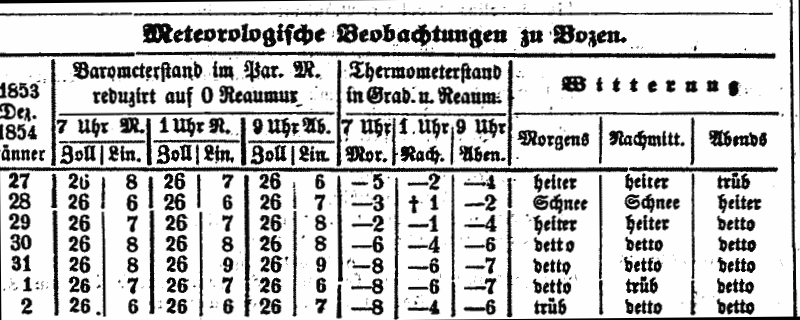

In [24]:
Image(filename=result2_name) 

## search table on different pages of an issue

Now we assume that only one page of an issue contains the desired table. Therefore we look for the best match.

In [25]:
# define template and location of journal pages here
template = cv2.imread('template2.png')  # template
image_dir = './wy_BZ_1854/01-04-1854'   # location of journal pages
result_dir = './BZ_1854_results'   # results

In [26]:
# initialize variables
init_thrs = 0.12 # initial threshold
step = 0.01 # step for increasing threshold
w, h = template.shape[:-1]
init_rot = -2.0 # initial rotation angle
end_rot = 2.0 # final rotation angle
rot_step = 0.25 # rotation step
tol = 0.05 # 5% extra border on each side
w_border = int(w*tol)
h_border = int(h*tol)

In [27]:
# create results folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

In [28]:
max_loc = 0
table_image = 'no_file'
for filename in os.listdir(image_dir):
    img_rgb = cv2.imread(os.path.join(image_dir,filename))
    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= init_thrs)
    n_loc = len(loc[0])
    print (filename, 'initial instances found : ', n_loc)
    if n_loc > max_loc:
        table_image = filename
        max_loc = n_loc
print ('maximum instances = ', max_loc, 'filename: ', table_image)

01-04-1854_0.png initial instances found :  0
01-04-1854_1.png initial instances found :  0
01-04-1854_3.png initial instances found :  0
01-04-1854_2.png initial instances found :  7
01-04-1854_5.png initial instances found :  0
01-04-1854_4.png initial instances found :  0
maximum instances =  7 filename:  01-04-1854_2.png


In [29]:
# run subroutine for iterative picture matching
img_rgb = cv2.imread(os.path.join(image_dir,table_image))
res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= init_thrs)
n_loc = len(loc[0])
print ('initial matches found : ', n_loc)

initial matches found :  7


In [30]:
location, threshold = find_picture_match(img_rgb, template, init_thrs, step, loc, w, h)

iteration converged at threshold =  0.13
number of matches found:  7


In [31]:
# these are the best matching locations
image = (location[::-1])
image

(array([104,  89,  89,  89,  89,  89,  89]),
 array([1068, 1398, 1399, 1400, 1401, 1402, 1403]))

In [32]:
#evaluate median location for cropping
loc0 = int(np.median(image[0]))
loc1 = int(np.median(image[1]))
loc0, loc1

(89, 1400)

In [33]:
# crop
crop_img = img_rgb[loc1:int(loc1+w), loc0:int(loc0+h)]

In [34]:
# save to file
result_name = 'result.png'
cv2.imwrite(result_name, crop_img)

True

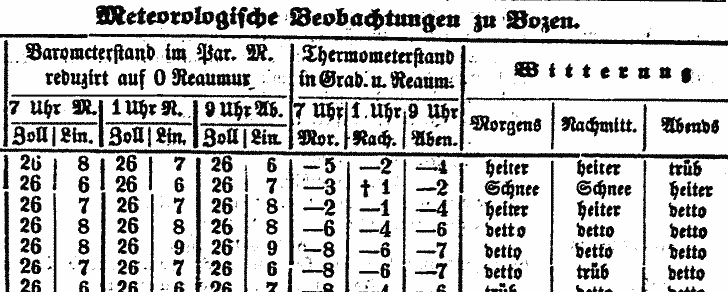

In [35]:
# what did we find?
Image(filename=result_name) 

## loop over whole year

Now we loop over all issues of the whole year. Not every issue contains the specified table, so we have to make a pre-selection. The trade-off between finding all tables and finding only correct matches can be tuned using the 'init_thrs'-parameter.

In [36]:
# define template and location of journal pages here
template = cv2.imread('template2.png')  # template
image_dir = './wy_BZ_1854'   # location of journal pages
result_dir = './BZ_1854_results'   # results

In [37]:
# initialize variables
init_thrs = 0.13 # initial threshold; this parameter determines the trade-off between finding all tables and getting false positives
step = 0.01 # step for increasing threshold
w, h = template.shape[:-1]
init_rot = -2.0 # initial rotation angle
end_rot = 2.0 # final rotation angle
rot_step = 0.25 # rotation step
tol = 0.05 # 5% extra border on each side
w_border = int(w*tol)
h_border = int(h*tol)

In [38]:
# create results folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

In [39]:
# pre-selection of issues and pages containing the specified table
dir_list = []
table_list  = []
for dirname in os.listdir(image_dir):
    print(dirname)
    max_loc = 0
    table_image = 'no_file'
    dirpath = os.path.join(image_dir,dirname)
    if os.path.isdir(dirpath):
        for filename in os.listdir(dirpath):
            #print (filename)
            img_rgb = cv2.imread(os.path.join(dirpath,filename))
            res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
            loc = np.where(res >= init_thrs)
            n_loc = len(loc[0])
            #print (filename, 'initial instances found : ', n_loc)
            if n_loc > max_loc:
                table_image = filename
                max_loc = n_loc
        print ('maximum instances = ', max_loc, 'filename: ', table_image)
        dir_list.append(dirname)
        table_list.append(table_image)

06-21-1854
maximum instances =  145 filename:  06-21-1854_5.png
05-31-1854
maximum instances =  47 filename:  05-31-1854_7.png
03-18-1854
maximum instances =  0 filename:  no_file
01-25-1854
maximum instances =  388 filename:  01-25-1854_3.png
11-25-1854
maximum instances =  590 filename:  11-25-1854_4.png
12-23-1854
maximum instances =  0 filename:  no_file
05-27-1854
maximum instances =  0 filename:  no_file
03-22-1854
maximum instances =  127 filename:  03-22-1854_3.png
04-26-1854
maximum instances =  162 filename:  04-26-1854_5.png
08-05-1854
maximum instances =  0 filename:  no_file
11-29-1854
maximum instances =  0 filename:  no_file
10-04-1854
maximum instances =  147 filename:  10-04-1854_3.png
08-09-1854
maximum instances =  0 filename:  no_file
06-17-1854
maximum instances =  0 filename:  no_file
02-15-1854
maximum instances =  343 filename:  02-15-1854_7.png
10-28-1854
maximum instances =  0 filename:  no_file
01-04-1854
maximum instances =  0 filename:  no_file
11-04-1854
m

In [40]:
for num, fname in enumerate(table_list):
    if fname != 'no_file':
        path = os.path.join(image_dir,dir_list[num],fname)
        #print (path)
        img_rgb = cv2.imread(path)
        res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= init_thrs)
        n_loc = len(loc[0])
        print (fname, 'initial instances found : ', n_loc)
        location, threshold = find_picture_match(img_rgb, template, init_thrs, step, loc, w, h)
        if threshold < 0.3:
            old_location = location
            thrs = threshold # threshold
            rotation = find_rotation_match(img_rgb, template, init_rot, end_rot, rot_step, thrs)
            rotated = imutils.rotate(template, rotation) # invert angle for rotating image
            res = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)
            loc = np.where(res >= thrs)
            n_loc = len(loc[0])
            print ('rotation = ', rotation, ' instances found : ', n_loc)
            location, threshold = find_picture_match(img_rgb, rotated, thrs, step, loc, w, h)
            image = (location[::-1])
            rot_image = True
            if len(image[0]) == 0:
                print ('no matches found, therefore no new locations; keep image without rotation')
                location = old_location
                image = (location[::-1])
                rot_image = False
            loc0 = int(np.median(image[0]))
            loc1 = int(np.median(image[1]))    
            crop_img = img_rgb[int(loc1-w_border):int(loc1+w+w_border), int(loc0-h_border):int(loc0+h+h_border)]
            result_name = os.path.join(result_dir,fname)
            if rot_image:
                rot_crop_img = imutils.rotate(crop_img, -rotation) # invert rotation for result (rotation applies to template)
                cv2.imwrite(result_name, rot_crop_img)
            else:
                cv2.imwrite(result_name, crop_img)
        else:
            image = (location[::-1])
            loc0 = int(np.median(image[0]))
            loc1 = int(np.median(image[1]))    
            crop_img = img_rgb[int(loc1-w_border):int(loc1+w+w_border), int(loc0-h_border):int(loc0+h+h_border)]
            result_name = os.path.join(result_dir,fname)
            cv2.imwrite(result_name, crop_img)
        print ('--------------------------------------------------------------------------------')

06-21-1854_5.png initial instances found :  145
iteration converged at threshold =  0.17000000000000004
number of matches found:  5
rotation =  -0.5  instances found :  46
iteration converged at threshold =  0.20000000000000007
number of matches found:  1
--------------------------------------------------------------------------------
05-31-1854_7.png initial instances found :  47
iteration converged at threshold =  0.21000000000000008
number of matches found:  1
rotation =  -0.25  instances found :  2
iteration converged at threshold =  0.22000000000000008
number of matches found:  2
--------------------------------------------------------------------------------
01-25-1854_3.png initial instances found :  388
iteration converged at threshold =  0.3200000000000002
number of matches found:  3
--------------------------------------------------------------------------------
11-25-1854_4.png initial instances found :  590
iteration converged at threshold =  0.27000000000000013
number of m

05-03-1854_5.png initial instances found :  130
iteration converged at threshold =  0.21000000000000008
number of matches found:  1
rotation =  -0.75  instances found :  8
iteration converged at threshold =  0.27000000000000013
number of matches found:  2
--------------------------------------------------------------------------------
07-12-1854_3.png initial instances found :  60
iteration converged at threshold =  0.16000000000000003
number of matches found:  12
rotation =  -0.75  instances found :  46
iteration converged at threshold =  0.20000000000000007
number of matches found:  2
--------------------------------------------------------------------------------
12-27-1854_3.png initial instances found :  56
iteration converged at threshold =  0.16000000000000003
number of matches found:  8
rotation =  -1.0  instances found :  228
iteration converged at threshold =  0.27000000000000013
number of matches found:  3
---------------------------------------------------------------------